# ECON 890: Problem Set 1
## Dylan Eldred

In [1]:
# Packages 
import numpy as np
import matplotlib.pyplot as plt
import time

In [22]:
start_time = time.time()

In [29]:
# Model Parameters

## Fixed Parameters
beta_discount= 0.9985 # Discount factor
alpha_death = 0.0009 # Probability of dying
lambda_layoff = 0.009 # Probability of being laid off
beta_alpha = beta_discount* (1 - alpha_death) # Discount factor, easier notation-wise
psi_f = 30
psi_u = 10
b = 0.5 # Unemployment Benefits
tax_rate = 0.5 # Initial guess is 0.5, value is in [0,1]

## Define Grids
w_node = 41
s_node = 41
h_node = 201
wage_grid = np.linspace(0,1,w_node) # Wages
search_grid = np.linspace(0,1,s_node) # Search Effort
hcap_grid = np.linspace(1,2,h_node) # Human Capital

# Search Effort Cost c(s) = 0.5 * s
def search_cost(s):
    return s * 0.5

# Contact Probability
def pi_s(s):
    return s**0.3

#Distributions of Human Capital and Wage

## Human Capital
# I struggled coding up the draws for human capital, so I framed it as a transition matrix based on unemployment probability and job separation probability
# If employed, human capital next period (h’) = h+1
h_prime = np.arange(h_node)+1
h_prime[-1] = h_node - 1

# If unemployed, lose psi_u units of human capital
h_unemp = np.arange(h_node) - psi_u
h_unemp[h_unemp<0] = 0

# If fired, lose psi_f units of human capital
h_fired = np.arange(h_node) - psi_f
h_fired[h_fired < 0] = 0

## Wage Distribution
wage_mean = 0.5
wage_var = 0.1
wage_stdev = np.sqrt(wage_var)

def norm_pdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
# hard coded normal pdf to make it easier to truncate
wage_dist = norm_pdf(wage_grid, wage_mean, wage_stdev)
pmf_wage = wage_dist/wage_dist.sum()

In [30]:
# Value Function Iteration
def vfi(tau,iterations=2000,tol=1e-3,verbose=False):
    # initial value guess
    u = np.ones(h_node)*((1-tau)*b)/(1-beta_alpha) # Initial guess for unemployed value: benefits net of taxes
    w = np.zeros((w_node,h_node)) # Initial guess for employed value: benefit of after-tax wage * human capital
    for iw, wage in enumerate(wage_grid):  # Loop over wage grid
        w[iw,:] = ((1 - tau) * wage * hcap_grid) /(1-beta_alpha)
     #Copy to update continuation values   
    u_prime = u.copy()
    w_prime = w.copy()
    supdiff = 1e9 # Large difference
    it = 0 #iteration counter
    # Iterate until convergence or max iterations reached
    while supdiff > tol and it < iterations:
        it +=1
        # Update Bellman for Employed Workers
        for ih in range(h_node): # Specifically, update employed value as a function of flow payoff and weighted future based on keeping/losing job
            ih_prime = h_prime[ih] # next-period human capital if keep job
            ih_fired = h_fired[ih] # next-period human capital if fired
            w_prime[:,ih] = (1 -tau)*wage_grid*hcap_grid[ih]+beta_alpha*((1-lambda_layoff)*w[:,ih_prime]+lambda_layoff*u[ih_fired])
        #Update Bellman for unemployed
        for ih in range(h_node):
            ih_after = h_unemp[ih]
            max_value = np.maximum(w[:,ih_after],u[ih_after])
            expected_offer = np.dot(pmf_wage,max_value)
            # Bellman RHS: benefit - search cost + discounted continuation
            rhs = (1 - tau) * b - search_cost(search_grid) + beta_alpha * ( #flow payoff
                pi_s(search_grid) * expected_offer + (1 - pi_s(search_grid)) * u[ih_after] # Expected value of future based on the probability of getting an offer
            ) # right hand side of bellman
            u_prime[ih] = rhs[np.argmax(rhs)] # Choose search effort, s, that maximizes the RHS of the bellman
        # Difference in utility
        diff_u = np.max(np.abs(u_prime-u)) 
        diff_w = np.max(np.abs(w_prime-w))
        supdiff = max(diff_u,diff_w) #Compare difference in utility between employment and unemployment
        u[:] = u_prime
        w[:,:] = w_prime

    # Solve for Optimal Policies: Search and reservation wage
    search_policy =np.zeros(h_node) #Initial guess
    reservation_wage = np.zeros(h_node) #Initial guess

    for ih in range(h_node):
        max_value = np.maximum(w[:, ih_after], u[ih_after])
        expected_offer = np.dot(pmf_wage, max_value)
        rhs = (1 - tau) * b - search_cost(search_grid) + beta_alpha * (
            pi_s(search_grid) * expected_offer + (1 - pi_s(search_grid)) * u[ih_after]
        )
        ih_after = h_unemp[ih]
        max_value = np.maximum(w[:, ih_after], u[ih_after])
        rhs = (1 - tau) * b - search_cost(search_grid) + beta_alpha * (
                pi_s(search_grid) * expected_offer + (1 - pi_s(search_grid)) * u[ih_after]
            ) 
        search_policy[ih] = search_grid[np.argmax(rhs)] # For each human capital draw, store optimal search effort and the reservation wage
        diff_wu = w[:, ih_after] - u[ih_after]  # Compare employed vs unemployed values
        accept_rule = np.where(diff_wu >=0)[0] # Wages worth accepting
        if accept_rule.size > 0:
            reservation_wage[ih] = wage_grid[accept_rule[0]]
        else:
            reservation_wage[ih] = wage_grid[-1]
    return u,w, search_policy, reservation_wage
    

In [31]:
# Simulation using VFI
def sim_vfi(u, w, search_policy, reservation_wage, tau, n=10000, T=200, burn=100, seed=315):
    rng = np.random.default_rng(seed)
    e = np.zeros(n, dtype=np.int8)  # 0=unemployed, 1=employed
    hcap_draws = rng.uniform(1, 2, size=n)
    hcap_index = np.searchsorted(hcap_grid, hcap_draws) - 1
    hcap_index = np.clip(hcap_index, 0, h_node - 1)
    wage_index = -1 * np.ones(n, dtype=np.int64)   # Changed (force integer array)

    u_rate, tax_revenue, ui_payment = [], [], []
    cdf_wage = np.cumsum(pmf_wage)

    for t in range(T):
        # --- Layoffs
        employed = np.where(e == 1)[0]
        if employed.size > 0:
            draws = rng.random(employed.size)
            laid_off = employed[draws < lambda_layoff]
            still_emp = employed[draws >= lambda_layoff]
            if laid_off.size > 0:
                e[laid_off] = 0
                hcap_index[laid_off] = h_fired[hcap_index[laid_off]]
            if still_emp.size > 0:
                hcap_index[still_emp] = h_prime[hcap_index[still_emp]]

        # --- Unemployed search
        unemp_index = np.where(e == 0)[0]
        if unemp_index.size > 0:
            search_choice = search_policy[hcap_index[unemp_index]]
            contact_prob = pi_s(search_choice)
            contacted = rng.random(unemp_index.size) < contact_prob
            contacting = unemp_index[contacted]
            if contacting.size > 0:
                 # Accept if offer >= reservation wage
                sample_w_index = np.searchsorted(cdf_wage, rng.random(contacting.size))
                sample_w_index = np.clip(sample_w_index, 0, w_node - 1)
                accept = wage_grid[sample_w_index] >= reservation_wage[hcap_index[contacting]]
                accepted = contacting[accept]
                if accepted.size > 0:
                    e[accepted] = 1
                    wage_index[accepted] = sample_w_index[accept].astype(np.int64)   # Changed
                    hcap_index[accepted] = h_unemp[hcap_index[accepted]]
                     # If rejected, stay unemployed but human capital drops
                rejected = contacting[~accept]
                if rejected.size > 0:
                    hcap_index[rejected] = h_unemp[hcap_index[rejected]]
            no_contact = unemp_index[~contacted]
            # No contact: stay unemployed, lose some human capital
            if no_contact.size > 0:
                hcap_index[no_contact] = h_unemp[hcap_index[no_contact]]

        # --- Aggregates
        employed_mask = (e == 1)
        unemp_rate = 1.0 - employed_mask.mean()
        wages = np.zeros(n)
        if employed_mask.any():
            wages[employed_mask] = wage_grid[wage_index[employed_mask].astype(int)] * hcap_grid[hcap_index[employed_mask]]   # Changed
        wage_total = wages.mean()
        ui_payout = unemp_rate * b
        tax_rev = tau * (wage_total + ui_payout)

        u_rate.append(unemp_rate)
        tax_revenue.append(tax_rev)
        ui_payment.append(ui_payout)

    return np.mean(u_rate[burn:]), np.mean(tax_revenue[burn:]), np.mean(ui_payment[burn:])

In [32]:
# Bisection Method to get optimal tax
tol_tau = 1e-3
iterations_tax = 20
def eq_tax(tol=tol_tau,max_iter=iterations_tax):
    tau_low = 0
    tau_high = 1
    tau = 0.5 #initial guess
    for tax_it in range(max_iter):
        u,w,search_policy, r_w = vfi(tau)
        avg_unemp,avg_tax_revenue, avg_ui = sim_vfi(u,w,search_policy,r_w,tau)
        budget_surplus = avg_tax_revenue - avg_ui
        if abs(budget_surplus) < tol:
            break
        if budget_surplus > 0: # Too much revenue → lower tau
            tau_high = tau
        else:
            tau_low = tau # Too little revenue → raise tau
        tau = 0.5*(tau_low+tau_high)
    return tau, u,w, search_policy, r_w, avg_unemp


Equilibrium results:
  tau = 0.014648
  unemployment = 0.0389


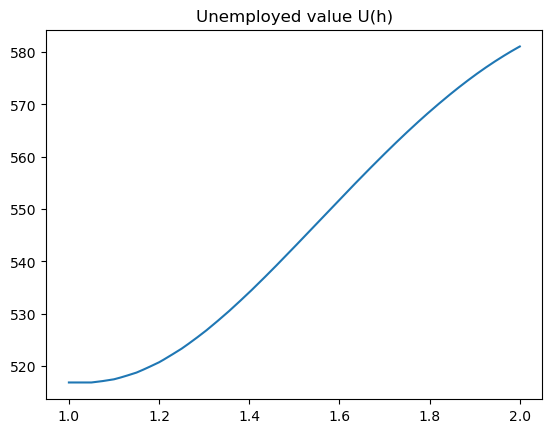

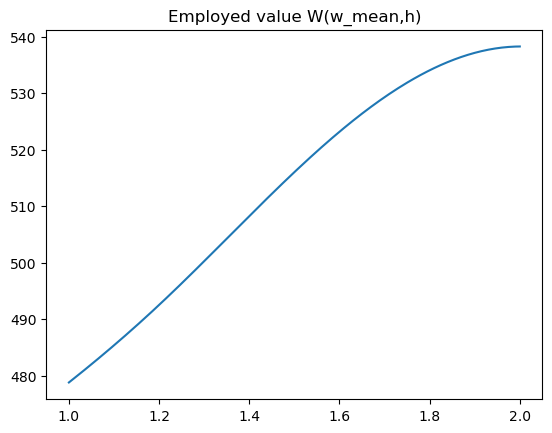

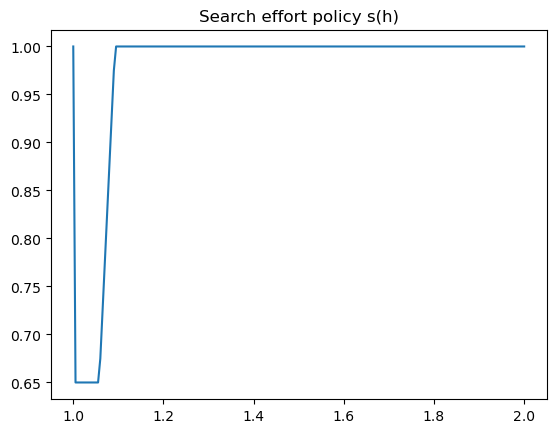

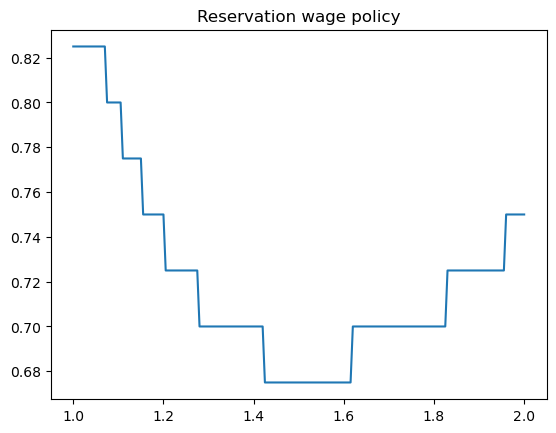

In [33]:
# Plots and Equilibrium Quantities
if __name__ == "__main__":
    tau, u, w, search_policy, r_w, unemp_eq = eq_tax()

    print("\nEquilibrium results:")
    print(f"  tau = {tau:.6f}")
    print(f"  unemployment = {unemp_eq:.4f}")

    # Plots
    wage_mean_index = np.argmin(np.abs(wage_grid - wage_mean))
    wage_at_mean = w[wage_mean_index, :]

    plt.figure(); plt.plot(hcap_grid, u); plt.title("Unemployed value U(h)"); plt.show()
    plt.figure(); plt.plot(hcap_grid, wage_at_mean); plt.title("Employed value W(w_mean,h)"); plt.show()
    plt.figure(); plt.plot(hcap_grid, search_policy); plt.title("Search effort policy s(h)"); plt.show()
    plt.figure(); plt.plot(hcap_grid, r_w); plt.title("Reservation wage policy"); plt.show()

In [28]:
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.4f} seconds")

Execution time: 59.5721 seconds
